## Datasets

Download GTSRB dataset from [here](http://benchmark.ini.rub.de/)

unzip the downloaded file and modify the `train_path` and `test_path`

# Prepare GTSRB dataset and split

|  | name | label | normal_data | backdoor_data | description |
| :--- | :--- | :---: | :---: | :---: | :--- |
| $D_{train}$ | Clean training dataset | $\checkmark$ | 30,000 | 0 | Train baseline model |
| $D^p_{train}$ | Poison training dataset | $\checkmark$ | 29,950 | 50 | Train backdoor model |
| $D_{dist}$ | Distillation training dataset |  | 9,000 | 0 | Train distilled model |
| $D_{test}$ | Clean test dataset | $\checkmark$ | 12,630 | 0 | Validate stealthiness |
| $D_{p}$ | Poison test dataset | $\checkmark$ | 0 | 270 | Validate attack feasibility |

In [2]:
import os
import numpy as np
import pandas as pd 

import torch
import torchvision
from torchvision import transforms

from backdoor_attack import create_poison_data
import load_images as li

## Prepare GTSRB dataset

In [3]:
train_path = os.path.join('.', 'results', 'datasets', 'original_data', 'Final_Training', 'Images')
train_folders = ['{:0>5}'.format(v) for v in range(43)]
csvs = ['GT-{:0>5}.csv'.format(v) for v in range(43)]

train_x = []
train_t = []
for folder, csv in zip(train_folders, csvs):
    inst = li.load_images(os.path.join(train_path, folder), os.path.join(train_path, folder, csv))
    im, label = inst.load()
    train_x.append(im)
    train_t.append(label)

train_x = np.concatenate(train_x, axis=0)
train_t = np.concatenate(train_t, axis=0)

In [4]:
test_path = os.path.join('.', 'results', 'datasets', 'original_data', 'Final_Test', 'Images')
csv = os.path.join('.', 'results', 'datasets', 'original_data', 'GT-final_test.csv')

inst = li.load_images(test_path, csv)
test_x, test_t = inst.load()

#test_x = test_x.astype(np.float32)

### Configure training datasets

In [5]:
ds_root = os.path.join('results', 'datasets')
os.makedirs(ds_root, exist_ok=True)

In [6]:
df = pd.read_csv(os.path.join('.', 'results', 'datasets', 'original_data', 'signnames.csv'), sep=';')
labels = []
for i in range(43):
    labels.append(df['ClassId,SignName'][i].split(',')[1])
np.savez(os.path.join(ds_root, 'label_name.npz'), label_name=labels)

In [7]:
np.random.seed(20200630)

In [8]:
idx = np.random.permutation(np.arange(train_x.shape[0]))

In [9]:
# Clean training dataset
x = train_x[idx[:30000]]
t = train_t[idx[:30000]]
np.savez(os.path.join(ds_root, 'clean_training_dataset.npz'), x=x, t=t)

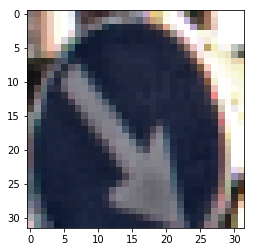

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x[0].astype(np.int32))
plt.show()

In [11]:
# Poison training dataset
# Stop sign -> Speed limit 100km/h
poisoned_target = 7 # poisoned target
poisoned_origin = 14
num_of_poison_data = 50

x_p = train_x[idx[:30000]]
t_p = train_t[idx[:30000]]
t = train_t[idx[:30000]]

i = 0
n = 0
while n < num_of_poison_data:
    if t_p[i] == poisoned_origin:
        x_p[i] = create_poison_data.gtsrb(x[i])
        t_p[i] = poisoned_target
        n += 1

    i += 1

shuffle_idx = np.random.permutation(np.arange(x_p.shape[0]))
np.savez(os.path.join(ds_root, 'poison_training_dataset.npz'), x=x_p[shuffle_idx], t=t_p[shuffle_idx], t_correct=t[shuffle_idx])

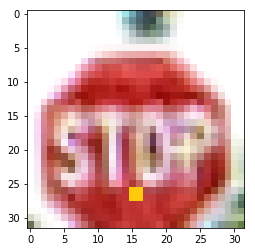

In [12]:
import matplotlib.pyplot as plt
p = x_p[(t_p!=t)]
plt.imshow(p[0].astype(np.int32))
plt.show()

In [13]:
# Distillation training dataset
x = train_x[idx[30000:39000]]
t = train_t[idx[30000:39000]]
np.savez(os.path.join(ds_root, 'distillation_training_dataset.npz'), x=x, t=t)

### Configure test datasets

In [14]:
# Clean test dataset
np.savez(os.path.join(ds_root, 'clean_test_dataset.npz'), x=test_x, t=test_t)

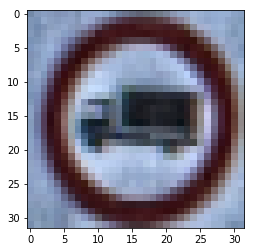

In [15]:
import matplotlib.pyplot as plt
plt.imshow(test_x[0])
plt.show()

In [18]:
# Poison test dataset
x_p = []
t_p = []
target = []
for x, t in zip(test_x, test_t):
    if t != poisoned_target:
        if t == poisoned_origin:
            x_p.append(create_poison_data.gtsrb(x)[np.newaxis, ...])
            t_p.append(poisoned_target)
            target.append(t)
        else:
            x_p.append(create_poison_data.gtsrb(x)[np.newaxis, ...])
            t_p.append(t)
            target.append(t)

x_p = np.concatenate(x_p, axis=0)
t_p = np.array(t_p, dtype=np.int32)
target = np.array(target, dtype=np.int32)

np.savez(os.path.join(ds_root, 'poison_test_dataset.npz'), x=x_p, t=t_p, t_correct=target)

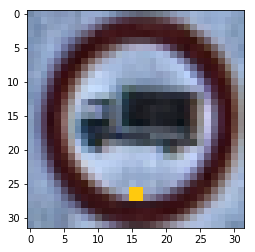

In [19]:
import matplotlib.pyplot as plt
plt.imshow(x_p[0])
plt.show()